## ATAC + MULTIOME (males) - september 2021

### Build anndata from cellatac output 

In [45]:
# Load libraries
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

In [46]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_sept2021/"
experiment_prefix = 'males_'
cellatac_outdir = '/warehouse/cellgeni/tic-1124/results200k/'


In [47]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

#### Make anndata object

In [50]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

In [51]:
adata

AnnData object with n_obs × n_vars = 55707 × 483200

In [52]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

06    8513
02    6878
01    6353
13    5731
11    5427
08    5335
12    5264
07    4628
04    2872
10    1461
09    1415
03    1111
05     719
Name: code, dtype: int64

In [53]:
# Sample from code 
sample_dictionary = {'01' : 'HCA_F_GON10687819', '02' : 'HCA_F_GON10687820', '03' : 'FCA_GND8768481', 
                    '04' : 'FCA_GND8768482', '05' : 'FCA_GND8768487', '06' : 'FCA_GND8795927',
                     '07' : 'FCA_GND8795928', '08' : 'HD_F_GON9479872', '09' : 'HD_F_GON9525611', 
                     '10' : 'HD_F_GON9525612', '11' : 'FCA_GND9332157', '12' : 'HD_F_GON9883958',
                     '13' : 'HD_F_GON9883955'
                    }
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

FCA_GND8795927       8513
HCA_F_GON10687820    6878
HCA_F_GON10687819    6353
HD_F_GON9883955      5731
FCA_GND9332157       5427
HD_F_GON9479872      5335
HD_F_GON9883958      5264
FCA_GND8795928       4628
FCA_GND8768482       2872
HD_F_GON9525612      1461
HD_F_GON9525611      1415
FCA_GND8768481       1111
FCA_GND8768487        719
Name: sample, dtype: int64

In [54]:
adata.obs.tail()

,code,sample
12-TTTGTGTGTCTAACCA-1,12,HD_F_GON9883958
12-TTTGTGTGTTAGGCTT-1,12,HD_F_GON9883958
12-TTTGTGTGTTCCAGTA-1,12,HD_F_GON9883958
12-TTTGTGTGTTTAGAAG-1,12,HD_F_GON9883958
12-TTTGTGTTCTCGTAGA-1,12,HD_F_GON9883958


#### Load peak annotations (done with R script by Emma)

In [55]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col=0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace=True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)

#### Doublecheck that these are all male samples 

In [56]:
adata.var['chromosome'] = [i.split(":")[0] for i in adata.var_names]
adata.var['chromosome'].value_counts(dropna = False)

chr1     41822
chr2     41069
chr3     33671
chr6     29020
chr5     28437
chr4     27250
chr7     25909
chr10    24348
chr11    23819
chr8     23277
chr12    23043
chr9     20682
chr17    17183
chr14    15285
chr15    15191
chr13    15109
chr16    14474
chrX     12850
chr20    12748
chr18    12498
chr19    10632
chr22     8162
chr21     6150
chrY       571
Name: chromosome, dtype: int64

In [57]:
chr_Y = adata[:, list(adata.var[adata.var['chromosome'] == "chrY"].index)]
chr_Y_df = pd.DataFrame(chr_Y.X.toarray(), index = chr_Y.obs_names, columns = chr_Y.var_names)

In [58]:
# Mapping of cells to individuals 
chr_Y.obs['barcode'] = chr_Y.obs_names
cells_celltypes = chr_Y.obs[['barcode', 'sample']]
cells_celltypes.head()

Trying to set attribute `.obs` of view, copying.


,barcode,sample
03-AAACGAAAGCTGAGGT-1,03-AAACGAAAGCTGAGGT-1,FCA_GND8768481
03-AAACGAACAATCATCG-1,03-AAACGAACAATCATCG-1,FCA_GND8768481
03-AAACGAACATGCACTA-1,03-AAACGAACATGCACTA-1,FCA_GND8768481
03-AAACTCGTCACCCGGA-1,03-AAACTCGTCACCCGGA-1,FCA_GND8768481
03-AAACTGCCAAGGGTAC-1,03-AAACTGCCAAGGGTAC-1,FCA_GND8768481


In [59]:
cells_mapping = cells_celltypes.groupby('sample').groups
# Sum by rows 
for key in cells_mapping: 
    # print(key)
    chr_Y_df.loc[key] = chr_Y_df.loc[cells_mapping[key]].sum(axis = 0)

rows_celltypes = list(np.unique(adata.obs['sample']))
chr_Y_df = chr_Y_df.loc[rows_celltypes, :]
chr_Y_df.sum(axis = 1)

FCA_GND8768481       15894.0
FCA_GND8768482       16682.0
FCA_GND8768487        5658.0
FCA_GND8795927       32556.0
FCA_GND8795928       31265.0
FCA_GND9332157       28052.0
HCA_F_GON10687819    12284.0
HCA_F_GON10687820    14140.0
HD_F_GON9479872      39446.0
HD_F_GON9525611      24994.0
HD_F_GON9525612      25950.0
HD_F_GON9883955      31468.0
HD_F_GON9883958      31555.0
dtype: float32

#### Load annotations of snRNAseq from MULTIOME samples 

1. Germ cells 

In [62]:
path_to_multiome = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [64]:
germcells = pd.read_csv(path_to_multiome + 'multiomics_male_germcells.csv')
germcells.head()

,Unnamed: 0,n_genes,sample,donor,Library_ATAC,Library_RNA,iRods_path,percent_mito,n_counts,batch,...,bh_pval,bonf_pval,pcw,lineage,celltype_samplespecific,S_score,G2M_score,phase,leiden,celltype
0,HCA_F_GON10713286_AAACGCGCACTGGCCA,5701,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.001894,18223.0,0,...,0.901686,1.000000,8.8,GermCells,NaN,1.146592,0.513035,S,2,PGC_mitotic
1,HCA_F_GON10713286_AACAGCAAGAGGAGGA,6154,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.002846,20717.0,0,...,0.901686,1.000000,8.8,GermCells,NaN,0.037504,-0.186892,S,0,PGC
2,HCA_F_GON10713286_AACAGCAAGCTAAAGG,5009,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.001948,15032.0,0,...,0.901686,1.000000,8.8,GermCells,NaN,-0.347650,-0.672939,G1,0,PGC
3,HCA_F_GON10713286_AACAGCAAGTCAATCA,8263,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.003338,38623.0,0,...,0.000037,0.010037,8.8,GermCells,NaN,0.018986,3.420874,G2M,2,PGC_mitotic
4,HCA_F_GON10713286_AACATCATCCACCCTG,5685,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.001917,17283.0,0,...,0.901686,1.000000,8.8,GermCells,NaN,0.281357,-0.657518,S,0,PGC


In [65]:
germcells['Library_ATAC'].value_counts()

HCA_F_GON10687819    475
HCA_F_GON10687820    194
HD_F_GON9525612       38
HD_F_GON9525611       32
Name: Library_ATAC, dtype: int64

In [66]:
code_correspondence = {'HCA_F_GON10687819' : '01', 'HCA_F_GON10687820' : '02', 'HD_F_GON9525612' : '10',
                      'HD_F_GON9525611' : '09'}

In [67]:
germcells['ATAC_code'] = germcells['Library_ATAC'].map(code_correspondence)

In [68]:
germcells['ATAC_code'].value_counts(dropna = False)

01    475
02    194
10     38
09     32
Name: ATAC_code, dtype: int64

In [69]:
germcells['barcode'] = [i.split('_')[-1] for i in germcells['Unnamed: 0']]

In [70]:
germcells['ATAC_barcode'] = germcells['ATAC_code'] + '-' + germcells['barcode'] + '-1'

In [80]:
germcells['celltype'].value_counts(dropna = False)

PGC                 239
preSpermatogonia    221
PGC_mitotic         152
GC                  105
Doublet              22
Name: celltype, dtype: int64

2. Somatic cells 

In [71]:
supporting = pd.read_csv(path_to_multiome + 'multiomics_male_somatic.csv')
supporting.head()

,Unnamed: 0,n_genes,sample,donor,Library_ATAC,Library_RNA,iRods_path,percent_mito,n_counts,batch,...,bonf_pval,pcw,lineage,celltype_samplespecific,S_score,G2M_score,phase,leiden,leiden_R,celltype
0,HCA_F_GON10713286_AAACATGCAGGTATTT,3875,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.002676,10070.0,0,...,1.000000,8.8,Mesenchymal_LHX9,NaN,1.507850,0.092105,S,7,7,Mesenchymal_LHX9
1,HCA_F_GON10713286_AAACATGCAGTTTACG,5139,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.005092,13619.0,0,...,1.000000,8.8,Sertoli,NaN,-0.091674,-0.706570,G1,4,4,Sertoli
2,HCA_F_GON10713286_AAACCAACAAGCTTAT,5234,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.007096,14606.0,0,...,1.000000,8.8,Sertoli,NaN,-0.039820,-0.939547,G1,0,0,Sertoli
3,HCA_F_GON10713286_AAACCAACATAACGGG,1195,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.007257,1487.0,0,...,1.000000,8.8,Sertoli,NaN,-0.002272,-0.006809,G1,0,0,Sertoli
4,HCA_F_GON10713286_AAACCGAAGAAGCTAG,4897,HCA_F_GON10713286,Hrv41,HCA_F_GON10687820,HCA_F_GON10713286,/seq/illumina/cellranger-arc/cellranger-arc101...,0.004505,11114.0,0,...,0.046413,8.8,Sertoli,NaN,0.127001,-0.411759,S,0,0,Sertoli


In [72]:
supporting['celltype'].value_counts()

Sertoli             6304
Mesenchymal_LHX9    2141
FetalLeydig         1235
early_sPAX8          601
Doublet              484
CoelEpi_LHX9         348
Name: celltype, dtype: int64

In [73]:
supporting['ATAC_code'] = supporting['Library_ATAC'].map(code_correspondence)

In [74]:
supporting['barcode'] = [i.split('_')[-1] for i in supporting['Unnamed: 0']]
supporting['ATAC_barcode'] = supporting['ATAC_code'] + '-' + supporting['barcode'] + '-1'

In [75]:
adata.obs['multiome_GermCells'] = adata.obs_names.map(pd.Series(germcells.celltype.values,index=germcells.ATAC_barcode).to_dict())

In [76]:
adata.obs['multiome_GermCells'].value_counts(dropna = False)

NaN                 54968
PGC                   239
preSpermatogonia      221
PGC_mitotic           152
GC                    105
Doublet                22
Name: multiome_GermCells, dtype: int64

In [77]:
adata.obs['multiome_Somatic'] = adata.obs_names.map(pd.Series(supporting.celltype.values,index=supporting.ATAC_barcode).to_dict())

In [78]:
adata.obs['multiome_Somatic'].value_counts(dropna = False)

NaN                 44594
Sertoli              6304
Mesenchymal_LHX9     2141
FetalLeydig          1235
early_sPAX8           601
Doublet               484
CoelEpi_LHX9          348
Name: multiome_Somatic, dtype: int64

#### Save binary data to layers

In [81]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1
adata

AnnData object with n_obs × n_vars = 55707 × 483200
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome'
    layers: 'binary_raw'

#### Peak filtering

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

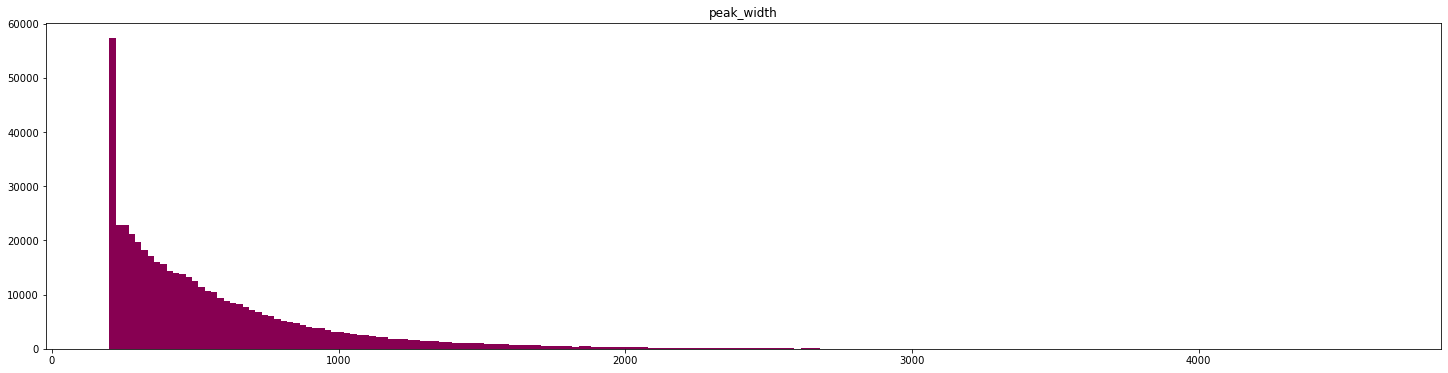

In [82]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [83]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

AnnData object with n_obs × n_vars = 55707 × 483200
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [84]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,chromosome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10003-10446,444,0,0,0,intergenic,NaN,NaN,58644,1,chr1,445,0.007988,0.007956,99.201178,445.0,6.100319
chr1:180674-181626,953,0,0,1,promoter,FO538757.2,ENSG00000279928,766,1,chr1,1859,0.033371,0.032826,96.662897,1859.0,7.528332
chr1:191306-191630,325,0,1,0,intron,FO538757.1,ENSG00000279457,3780,1,chr1,305,0.005475,0.005460,99.452493,305.0,5.723585
chr1:267865-268092,228,0,0,0,intergenic,NaN,NaN,67542,1,chr1,511,0.009173,0.009131,99.082701,511.0,6.238325
chr1:586070-586287,218,0,0,0,intergenic,NaN,NaN,100366,1,chr1,451,0.008096,0.008063,99.190407,451.0,6.113682


array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

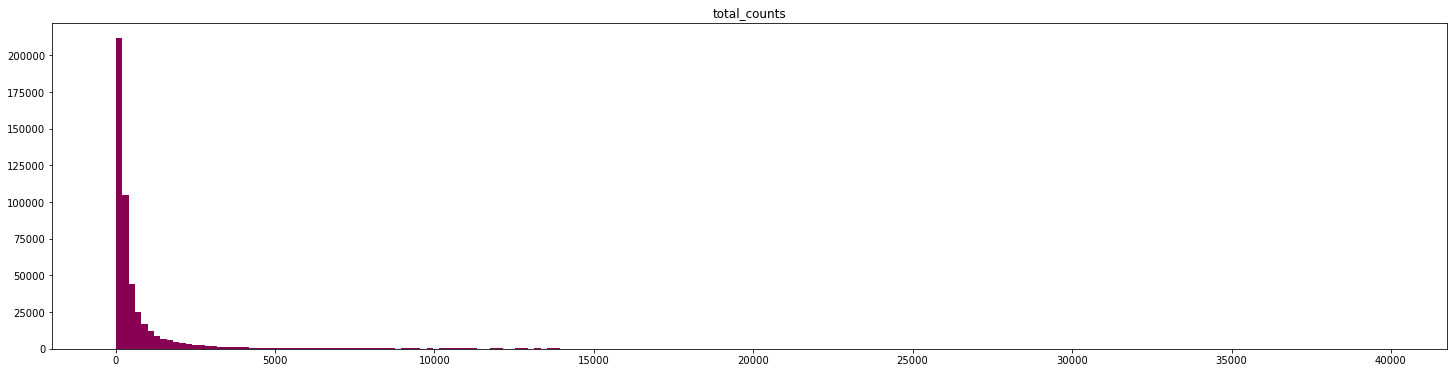

In [85]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [86]:
thirty_percent = len(adata.obs_names) / 100 * 30
point_one_percent = len(adata.obs_names) / 100 * 0.1
print("30% : {}".format(thirty_percent))
print("0.1% : {}".format(point_one_percent))

30% : 16712.100000000002
0.1% : 55.70700000000001


In [87]:
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > point_one_percent]
adata = adata[:,adata.var.total_counts < thirty_percent]
adata

View of AnnData object with n_obs × n_vars = 55707 × 468017
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [88]:
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 55707 × 466223
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [89]:
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 55707 × 414300
    obs: 'code', 'sample', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [90]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,chromosome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:816748-817444,697,0,0,0,intergenic,NaN,NaN,106483,0,chr1,816,0.014648,0.014542,98.535193,816.0,6.705639
chr1:817739-818222,484,0,0,0,intergenic,NaN,NaN,105705,0,chr1,289,0.005188,0.005174,99.481214,289.0,5.669881
chr1:818798-819092,295,0,0,0,intergenic,NaN,NaN,104835,0,chr1,168,0.003016,0.003011,99.698422,168.0,5.129899
chr1:825790-826054,265,0,0,0,intergenic,NaN,NaN,97873,0,chr1,378,0.006786,0.006763,99.321450,378.0,5.937536
chr1:826607-827807,1201,0,0,0,intergenic,NaN,NaN,96120,0,chr1,7354,0.132012,0.123997,86.798787,7354.0,8.903135


In [91]:
adata.var['annotation'].value_counts()

intergenic    190264
intron        168013
exon           43128
promoter       12895
Name: annotation, dtype: int64

In [92]:
adata.obs.head()

,code,sample,multiome_GermCells,multiome_Somatic
03-AAACGAAAGCTGAGGT-1,03,FCA_GND8768481,NaN,NaN
03-AAACGAACAATCATCG-1,03,FCA_GND8768481,NaN,NaN
03-AAACGAACATGCACTA-1,03,FCA_GND8768481,NaN,NaN
03-AAACTCGTCACCCGGA-1,03,FCA_GND8768481,NaN,NaN
03-AAACTGCCAAGGGTAC-1,03,FCA_GND8768481,NaN,NaN


In [93]:
### Filter peaks that are not accessible in at least 5% of cells from a coarse cluster
min_frac=0.05
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 55707 × 414300
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [94]:
adata.obs.head()

,cellatac_clusters
03-AAACGAAAGCTGAGGT-1,18
03-AAACGAACAATCATCG-1,18
03-AAACGAACATGCACTA-1,3
03-AAACTCGTCACCCGGA-1,18
03-AAACTGCCAAGGGTAC-1,31


In [95]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [96]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [97]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [98]:
cl_peak_frac.max(0).shape

(1, 414300)

In [99]:
bool_matrix = cl_peak_frac.max(0) > min_frac
bool_matrix.shape

(1, 414300)

In [100]:
bool_vector = np.squeeze(np.asarray(bool_matrix))
bool_vector.shape

(414300,)

In [101]:
adata = adata[:, bool_vector]

In [102]:
adata

View of AnnData object with n_obs × n_vars = 55707 × 184906
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [103]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

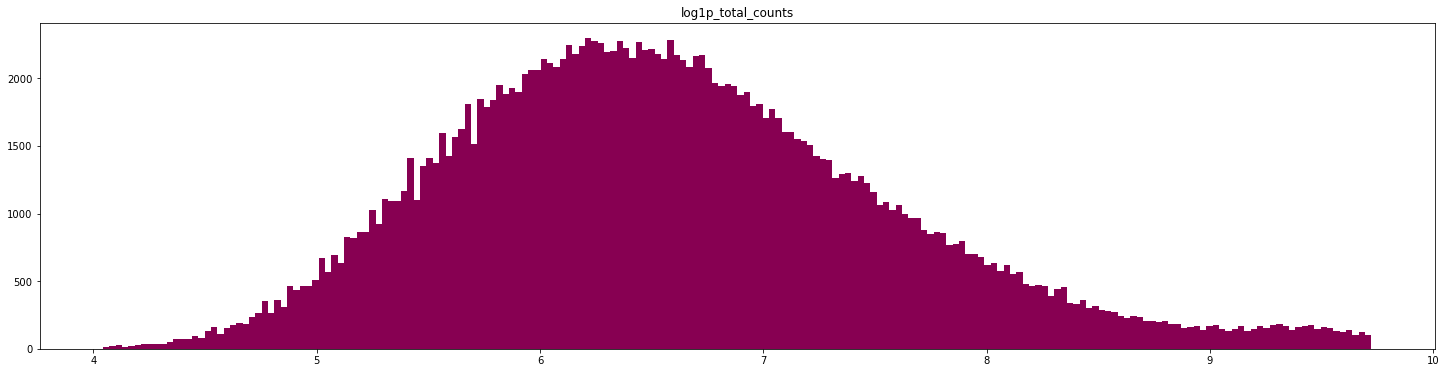

In [104]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

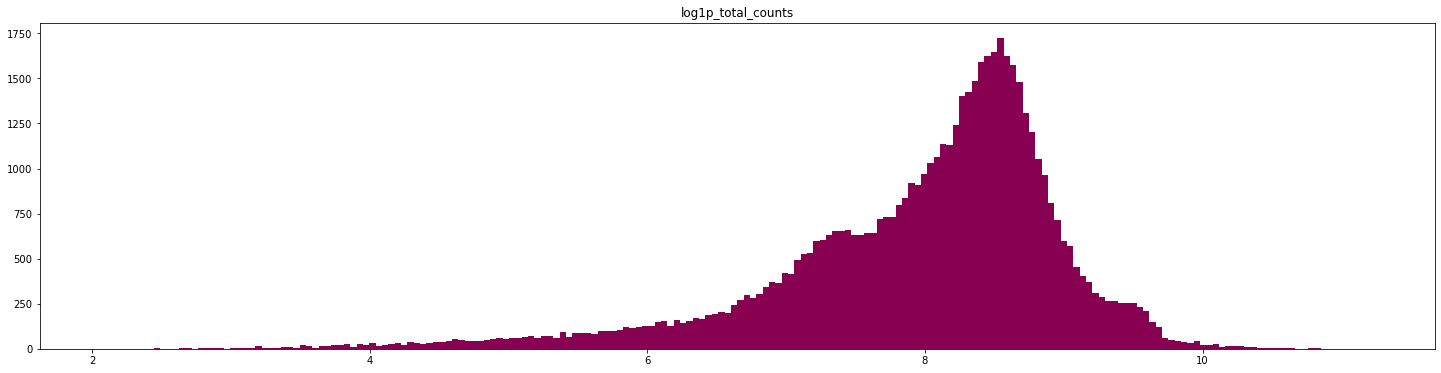

In [105]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [106]:
adata.obs['multiome_GermCells'] = adata.obs_names.map(pd.Series(germcells.celltype.values,index=germcells.ATAC_barcode).to_dict())
adata.obs['multiome_Somatic'] = adata.obs_names.map(pd.Series(supporting.celltype.values,index=supporting.ATAC_barcode).to_dict())

In [107]:
adata.obs.groupby('multiome_GermCells', as_index=False)['log1p_total_counts'].mean()

,multiome_GermCells,log1p_total_counts
0,Doublet,9.454344
1,GC,6.839671
2,PGC,6.697628
3,PGC_mitotic,6.855468
4,preSpermatogonia,6.947725


In [108]:
adata.obs['multiome_GermCells'].value_counts()

PGC                 239
preSpermatogonia    221
PGC_mitotic         152
GC                  105
Doublet              22
Name: multiome_GermCells, dtype: int64

In [109]:
adata.obs.groupby('multiome_Somatic', as_index=False)['log1p_total_counts'].mean()

,multiome_Somatic,log1p_total_counts
0,CoelEpi_LHX9,6.867040
1,Doublet,6.347393
2,FetalLeydig,7.575802
3,Mesenchymal_LHX9,7.195584
4,Sertoli,7.452519
5,early_sPAX8,6.962538


In [111]:
adata.obs['multiome_Somatic'].value_counts()

Sertoli             6304
Mesenchymal_LHX9    2141
FetalLeydig         1235
early_sPAX8          601
Doublet              484
CoelEpi_LHX9         348
Name: multiome_Somatic, dtype: int64

In [115]:
bdata = adata[adata.obs.log1p_total_counts >= 5]
bdata

View of AnnData object with n_obs × n_vars = 54542 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [116]:
bdata.obs['multiome_Somatic'].value_counts()

Sertoli             5922
Mesenchymal_LHX9    2017
FetalLeydig         1155
early_sPAX8          558
Doublet              413
CoelEpi_LHX9         310
Name: multiome_Somatic, dtype: int64

In [117]:
bdata.obs['multiome_GermCells'].value_counts()

PGC                 219
preSpermatogonia    201
PGC_mitotic         142
GC                   97
Doublet              22
Name: multiome_GermCells, dtype: int64

In [118]:
## Write output anndata
bdata.write_h5ad(output["h5ad"])

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'multiome_GermCells' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'multiome_Somatic' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'chromosome' as categorical


#### End of notebook